In [ ]:
# Add scripts directory to sys.path to import marc21_countries
import sys
import os
sys.path.append(os.path.abspath('/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/scripts'))

# All imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, concat, lit, regexp_replace, regexp_extract, when, floor, row_number, broadcast, collect_list, lower
from pyspark.sql.types import StringType
from pyspark.sql.window import Window

from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import pandas as pd

from marc21_countries import country_mapping

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define earth-tone palette
denver_palette = ['#DBEFBC', '#AEC1D7', '#8093F1', '#72DDF7', '#E8AEB7', '#FAA381']
sns.set_palette(denver_palette)

# Define custom colormap for heatmap
colors = ['#DBEFBC', '#DFDFBB', '#E2CFBA', '#E5BFB9', '#E8AEB7']  
denver_cmap = mcolors.LinearSegmentedColormap.from_list("denver_cmap", colors)

In [ ]:
os.getcwd()

In [ ]:
# Initialize Spark session
spark = (SparkSession
         .builder
         .appName("OpenLib EDA")
         .master("local[*]")
         .config("spark.sql.shuffle.partitions", "200")
         .getOrCreate()
        )

# spark = SparkSession.builder \
#     .appName("Open Library EDA") \
#     .master("local[*]") \
#     .config("spark.driver.memory", "10g") \
#     .config("spark.executor.memory", "6g") \
#     .config("spark.memory.offHeap.enabled", "true") \
#     .config("spark.memory.offHeap.size", "4g") \
#     .config("spark.sql.shuffle.partitions", "200") \
#     .config("spark.default.parallelism", "200") \
#     .getOrCreate()

# Load partitioned DataFrames

In [ ]:
eds_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/eds_partitioned"
# works_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/works_partitioned"
authors_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/authors_partitioned"

df_eds_final = spark.read.parquet(eds_output_path)
# df_works_final = spark.read.parquet(works_output_path)
df_authors_final = spark.read.parquet(authors_output_path).select("author_key", "name").distinct()


In [ ]:
# Inspect schemas
df_eds_final.printSchema()
# df_works_final.printSchema()
df_authors_final.printSchema()

# Preprocessing

In [ ]:
""" df_eds 1 will be used for:
    timeline
    top countries (all time)
    top subjects (all time)
    top subjects per top country (all time)
    top countries per top subject (all time)
    top countries per decade
    top subjects per decade
    top subjects per top country per decade
    top counties per top subject per decade

    note: make sure to explode subjects for subject-related tasks
"""
df_eds1 = (df_eds_final
                .withColumn("year", 
                            when(regexp_extract(col("publish_date"), r"(\d{4})", 1) != "",
                                 regexp_extract(col("publish_date"), r"(\d{4})", 1)
                                ).otherwise(None)
                           )
                .withColumn("decade",
                            when(col("year").isNotNull(),
                                 concat((floor(col("year") / 10) * 10).cast("string"), lit("s"))
                                ).otherwise(lit("Unknown"))
                           )
                .filter(col("year").isNotNull() & col("year").between(1900, 2020))
                .withColumn("publish_country",
                            lower(regexp_replace(col("publish_country"), r"^-", ""))
                           )
                .join(broadcast(spark.createDataFrame(list(country_mapping.items()),["publish_country", "country"])),
                      on="publish_country",
                      how="left"
                     )
                .withColumn("country",
                            when(col("country").isNotNull(),
                                 col("country")
                                ).otherwise(lit("Unknown"))
                           )
                .select("decade", "country", "subjects")
               )

In [ ]:
df_eds1.columns

# Descriptives

## 1. Timeline of Editions by Decade (1900-2025)

In [54]:
print(f"Total Number of Publications from 1900-2025: {df_eds1.count():,}")

Total Number of Publications from 1900-2025: 136,386,008


In [55]:
df_decade_counts = (df_eds1
                    .groupBy("decade")
                    .count()
                    .orderBy("decade")
                    .toPandas()
                   )

In [56]:
df_decade_counts

,decade,count
0,1900s,1974567
1,1910s,1748241
2,1920s,1717966
3,1930s,1790097
4,1940s,1859055
5,1950s,2883122
6,1960s,6850482
7,1970s,12540296
8,1980s,19159663
9,1990s,26108903


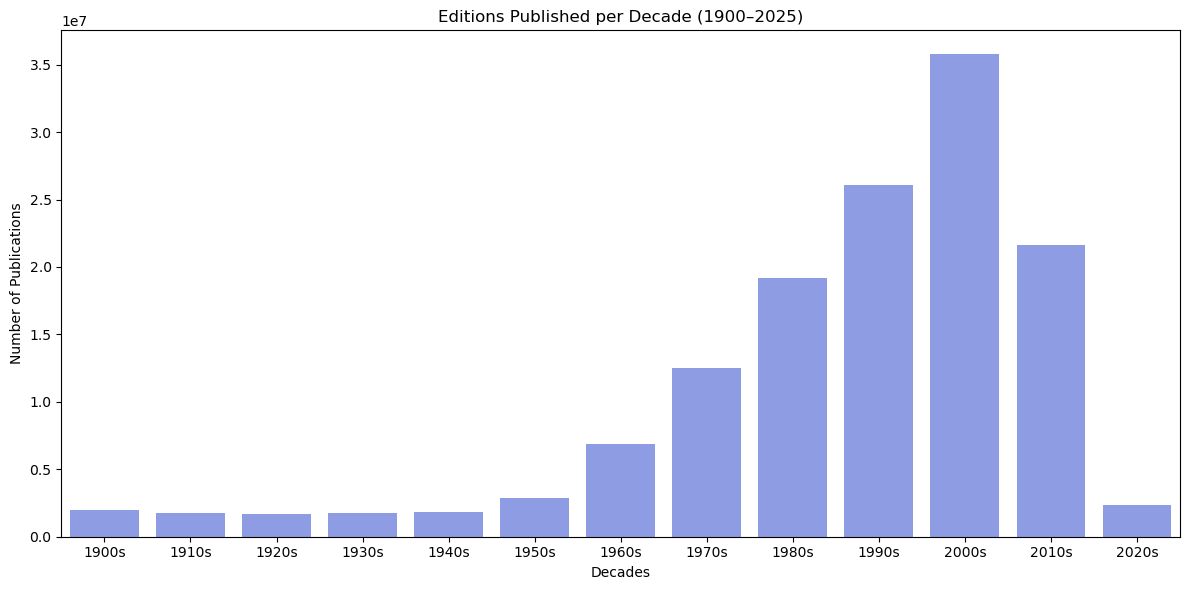

<Figure size 640x480 with 0 Axes>

In [57]:
# Plot Timeline
plt.figure(figsize=(12, 6))
sns.barplot(x="decade", y="count", data=df_decade_counts, color="#8093F1")
plt.title("Editions Published per Decade (1900–2025)")
plt.xlabel("Decades")
plt.ylabel("Number of Publications")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/plots/decade_counts.png")

# 2. Countries with the Most Publications (1900-2025)

In [58]:
df_country_counts = (df_eds1
                     .filter(col("country") != "Unknown")
                     .withColumn("country",
                                 when(col("country") == "United States of America", "USA")
                                 .when(col("country") == "United Kingdom", "UK")
                                 .otherwise(col("country")))
                     .groupBy("country")
                     .count()
                     .orderBy(col("count").desc())
                     .limit(20)
                     .toPandas()
                    )

In [59]:
df_country_counts

,country,count
0,USA,30666409
1,UK,10843031
2,Canada,2863827
3,Russia,935869
4,Germany,905490
5,China,901327
6,France,516194
7,Japan,409248
8,Italy,333223
9,Korea (South),220803


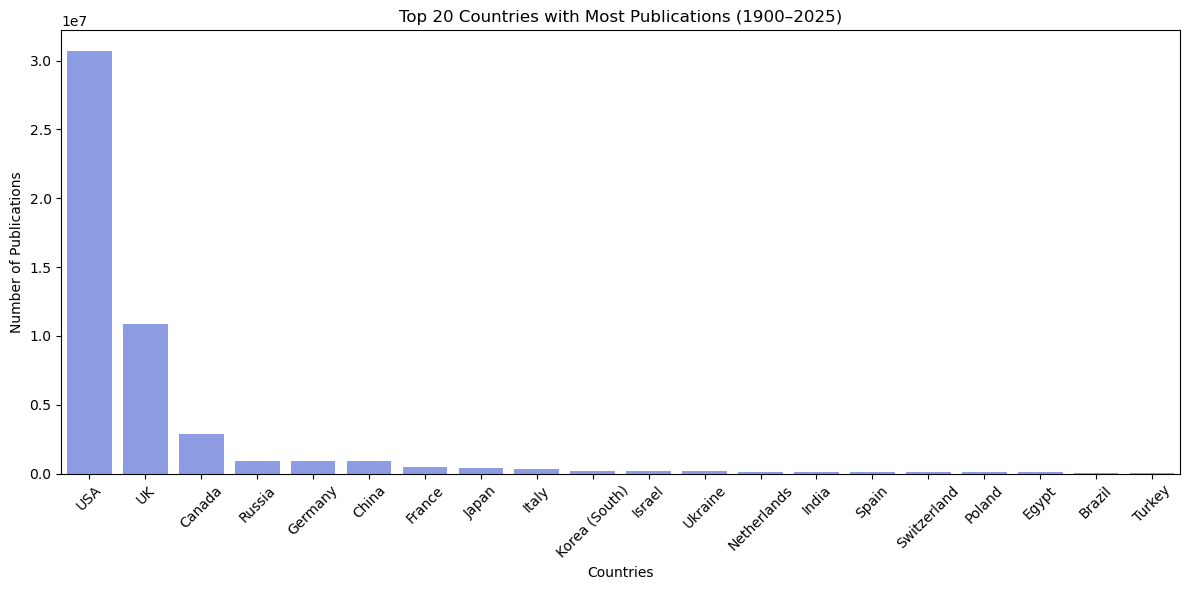

<Figure size 640x480 with 0 Axes>

In [60]:
# Plot Top Countries
plt.figure(figsize=(12, 6))
sns.barplot(x="country", y="count", data=df_country_counts, color="#8093F1")
plt.title("Top 20 Countries with Most Publications (1900–2025)")
plt.xlabel("Countries")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/plots/country_counts.png")

In [61]:
"""Just for fun, here's the full list! Uncomment if you're bored!"""

# df_country_counts_full = (df_eds1
#                      .filter(col("country") != "Unknown")
#                      .withColumn("country",
#                                  when(col("country") == "United States of America", "USA")
#                                  .when(col("country") == "United Kingdom", "UK")
#                                  .otherwise(col("country")))
#                      .groupBy("country")
#                      .count()
#                      .orderBy(col("count").desc())
#                      .toPandas()
#                     )
# df_country_counts_full.to_csv("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/extras/full_country_counts.csv", index=False)


"Just for fun, here's the full list! Uncomment if you're bored!"

## 3. Top Subjects Globally (1900-2025)

In [62]:
""" Let's clean up the subjects first. """
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# Initialize NLTK resources
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [63]:
@udf(returnType=StringType())
def clean_subject(subject):
    if not subject:
        return None
    # Lowercase and remove special characters
    subject = subject.lower()
    subject = re.sub(r'[^a-z\s]', ' ', subject)
    # Tokenize
    tokens = word_tokenize(subject)
    # Remove stopwords, short tokens, and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) >= 3]
    # Map synonyms
    tokens = [synonym_map.get(token, token) for token in tokens]
    # Remove duplicates and join
    tokens = list(dict.fromkeys(tokens))  # Preserve order
    return ' '.join(tokens) if tokens else None

In [64]:
df_subject_counts = (df_eds1
                     .withColumn("subject", explode(col("subjects")))
                     .filter(col("subject").isNotNull())
                     .withColumn("cleaned_subject", clean_subject(col("subject")))
                     .filter(col("cleaned_subject").isNotNull())
                     .groupBy("cleaned_subject")
                     .count()
                     .orderBy(col("count").desc())
                     .limit(50)
                     .cache()
                    )